In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

In [ ]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [ ]:
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train.shape

TensorShape([60000, 32, 32])

In [ ]:
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train.shape

TensorShape([60000, 32, 32, 1])

In [ ]:
x_val = x_train[-2000:,:,:,:] 
y_val = y_train[-2000:] 
x_train = x_train[:-2000,:,:,:] 
y_train = y_train[:-2000]

In [ ]:
# base model
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
# model.summary()

In [ ]:
# base model accuracy
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history_base = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
907/907 [==============================] - 31s 33ms/step - loss: 1.3326 - accuracy: 0.5190 - val_loss: 0.2899 - val_accuracy: 0.9260
Epoch 2/5
907/907 [==============================] - 21s 23ms/step - loss: 0.3357 - accuracy: 0.8936 - val_loss: 0.1858 - val_accuracy: 0.9505
Epoch 3/5
907/907 [==============================] - 20s 22ms/step - loss: 0.2623 - accuracy: 0.9158 - val_loss: 0.1506 - val_accuracy: 0.9580
Epoch 4/5
907/907 [==============================] - 21s 23ms/step - loss: 0.2177 - accuracy: 0.9308 - val_loss: 0.1459 - val_accuracy: 0.9610
Epoch 5/5
907/907 [==============================] - 22s 24ms/step - loss: 0.1958 - accuracy: 0.9371 - val_loss: 0.1066 - val_accuracy: 0.9760


In [ ]:
# Test baseline accuracy
import tempfile

_, baseline_model_accuracy = model.evaluate(x_test,y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)


Baseline test accuracy: 0.9498000144958496


In [ ]:
# base model saved location
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  /tmp/tmp_qoqff7i.h5


In [ ]:
###############################
########### PRUNING ###########
###############################

In [ ]:
pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 6.8 MB/s 


In [ ]:
## Prunning the entire dataset

import tensorflow_model_optimization as tfmot
import numpy as np

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# batch_size & epochs stay the same as the baseline model
batch_size = 64
epochs = 5


# Define model for pruning.
# For the pruning schedule, we start at the sparsity level 50% 
# and gradually train the model to reach 90% sparsity. 
# 90% of the weight tensor is going to be pruned away.

x = 0.2
sparsity = []
acc = []
while x <= 0.9:
  print("current x is: ",x)
  sparsity.append(x)
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(x, begin_step=0, frequency=100)
  }
  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

  history_pruned = model_for_pruning.fit(x_train,y_train,
                      batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),
                      callbacks=callbacks)
    
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(x_train,y_train, verbose=0)

  print("current x is: ",x, "and model acc is: ",model_for_pruning_accuracy)
  acc.append(model_for_pruning_accuracy)
  print("sparsity: ", sparsity)
  print("accuracy list: ", acc)
  x += 0.1

# model_for_pruning.summary()

current x is:  0.2
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


907/907 [==============================] - 35s 36ms/step - loss: 0.1708 - accuracy: 0.9456 - val_loss: 0.1041 - val_accuracy: 0.9705
Epoch 2/5
907/907 [==============================] - 21s 23ms/step - loss: 0.1554 - accuracy: 0.9508 - val_loss: 0.1043 - val_accuracy: 0.9720
Epoch 3/5
907/907 [==============================] - 22s 24ms/step - loss: 0.1446 - accuracy: 0.9536 - val_loss: 0.1051 - val_accuracy: 0.9700
Epoch 4/5
907/907 [==============================] - 22s 25ms/step - loss: 0.1333 - accuracy: 0.9581 - val_loss: 0.0890 - val_accuracy: 0.9775
Epoch 5/5
907/907 [==============================] - 23s 25ms/step - loss: 0.1255 - accuracy: 0.9600 - val_loss: 0.0834 - val_accuracy: 0.9790
current x is:  0.2 and model acc is:  0.9628275632858276
sparsity:  [0.2]
accuracy list:  [0.9628275632858276]
current x is:  0.30000000000000004
Epoch 1/5
907/907 [==============================] - 25s 25ms/step - loss: 0.1161 - accuracy: 0.9632 - val_loss: 0.0835 - val_accuracy: 0.9780
Epoch 

In [ ]:
sparsity = [round(x, 2) for x in sparsity]
sparsity

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
acc

[0.9628275632858276,
 0.9632586240768433,
 0.9733275771141052,
 0.9762758612632751,
 0.9841896295547485,
 0.982672393321991,
 0.9830689430236816,
 0.9738620519638062]

In [ ]:
# # fit the pruned model

# logdir = tempfile.mkdtemp()

# callbacks = [
#   tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
# ]

# history_pruned = model_for_pruning.fit(x_train,y_train,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

In [ ]:
# Test out pruned model accuracy
# _, model_for_pruning_accuracy = model_for_pruning.evaluate(
#    x_train,y_train, verbose=0)

In [ ]:
# compare results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9498000144958496
Pruned test accuracy: 0.9738620519638062


In [ ]:
# Once our pre-trained model achieved desirable accuracy
# we save the model trained model and make it “prunable”
# _, keras_file = tempfile.mkstemp('.h5')
# tf.keras.models.save_model(model_for_pruning, keras_file, include_optimizer=False)
# print('Saved baseline model to:', keras_file)

In [ ]:
compression_ratio = [1/x for x in sparsity]
compression_ratio

[5.0,
 3.3333333333333335,
 2.5,
 2.0,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111112]

In [ ]:
acc

[0.9628275632858276,
 0.9632586240768433,
 0.9733275771141052,
 0.9762758612632751,
 0.9841896295547485,
 0.982672393321991,
 0.9830689430236816,
 0.9738620519638062]

In [ ]:
# pruned model saved
_, pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', pruned_keras_file)
tf.keras.models.save_model(model_for_pruning, pruned_keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpclc6o366.h5


In [ ]:
###############################
###### PRUNING RESULT #########
###############################

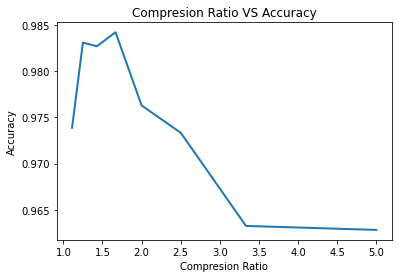

In [ ]:
# compression ratio vs accuracy graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.scatter(compression_rat, acc)
ax.plot(compression_ratio, acc, linewidth=2.0)
plt.xlabel('Compresion Ratio')
plt.ylabel('Accuracy')
plt.title('Compresion Ratio VS Accuracy')
plt.show()

In [ ]:
# accuracy results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy (90% pruned rate):', model_for_pruning_accuracy)

Baseline test accuracy: 0.9498000144958496
Pruned test accuracy (90% pruned rate): 0.9738620519638062


In [ ]:
# pruned model summary
# model_for_pruning.summary()

In [ ]:
# base model summary
# model.summary()

In [ ]:
# helper function to get model size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))

Size of gzipped baseline Keras model: 233687.00 bytes
Size of gzipped pruned Keras model: 60611.00 bytes


In [ ]:
# confusion matrix for based model
from sklearn.metrics import confusion_matrix
import numpy as np
test_predictions = model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

313/313 [==============================] - 2s 6ms/step


array([[ 970,    0,    1,    0,    0,    0,    4,    1,    4,    0],
       [   0, 1115,    3,    5,    0,    0,    2,    2,    7,    1],
       [   4,    1, 1009,    2,    3,    0,    0,   11,    2,    0],
       [   0,    0,    6,  991,    0,    3,    0,    7,    2,    1],
       [   1,    0,    4,    2,  959,    0,    1,    1,    1,   13],
       [   5,    0,    0,   18,    0,  852,    6,    1,    6,    4],
       [   6,    2,    2,    0,    1,    5,  940,    0,    2,    0],
       [   2,    1,   12,    7,    1,    2,    0,  991,    1,   11],
       [   4,    0,    4,    8,    2,    4,    1,    7,  938,    6],
       [   4,    3,    1,   11,    8,    4,    0,    4,   10,  964]])

In [ ]:
# confusion matrix for pruned model
p_test_predictions = model_for_pruning.predict(x_test)
p_confusion = confusion_matrix(y_test, np.argmax(p_test_predictions,axis=1))
p_confusion

313/313 [==============================] - 2s 6ms/step


array([[ 970,    0,    1,    0,    0,    0,    4,    1,    4,    0],
       [   0, 1115,    3,    5,    0,    0,    2,    2,    7,    1],
       [   4,    1, 1009,    2,    3,    0,    0,   11,    2,    0],
       [   0,    0,    6,  991,    0,    3,    0,    7,    2,    1],
       [   1,    0,    4,    2,  959,    0,    1,    1,    1,   13],
       [   5,    0,    0,   18,    0,  852,    6,    1,    6,    4],
       [   6,    2,    2,    0,    1,    5,  940,    0,    2,    0],
       [   2,    1,   12,    7,    1,    2,    0,  991,    1,   11],
       [   4,    0,    4,    8,    2,    4,    1,    7,  938,    6],
       [   4,    3,    1,   11,    8,    4,    0,    4,   10,  964]])

In [ ]:
###############################
######## Quantization #########
###############################

In [ ]:
## Quantization 
import tensorflow_model_optimization as tfmot

model_quant = tfmot.quantization.keras.quantize_model(model)
model_quant.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model_quant.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 28, 28, 6)        171       
 erV2)                                                           
                                                                 
 quant_average_pooling2d (Qu  (None, 14, 14, 6)        3         
 antizeWrapperV2)                                                
                                                                 
 quant_activation (QuantizeW  (None, 14, 14, 6)        1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 10, 10, 16)       2

In [ ]:
model_quant.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
907/907 [==============================] - 30s 32ms/step - loss: 0.1392 - accuracy: 0.9562 - val_loss: 0.0735 - val_accuracy: 0.9825
Epoch 2/5
907/907 [==============================] - 25s 27ms/step - loss: 0.1148 - accuracy: 0.9635 - val_loss: 0.0887 - val_accuracy: 0.9790
Epoch 3/5
907/907 [==============================] - 26s 28ms/step - loss: 0.1100 - accuracy: 0.9655 - val_loss: 0.0820 - val_accuracy: 0.9785
Epoch 4/5
907/907 [==============================] - 25s 27ms/step - loss: 0.1018 - accuracy: 0.9684 - val_loss: 0.0660 - val_accuracy: 0.9855
Epoch 5/5
907/907 [==============================] - 25s 27ms/step - loss: 0.0973 - accuracy: 0.9689 - val_loss: 0.0740 - val_accuracy: 0.9855


In [ ]:
# quant model saved
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
quant_tflite_model = converter.convert()

_, quant_tflite_file = tempfile.mkstemp('.h5')

with open(quant_tflite_file, 'wb') as f:
  f.write(quant_tflite_model)

print('Saved pruned TFLite model to:', quant_tflite_file)


Saved pruned TFLite model to: /tmp/tmp3pz2s139.h5


In [ ]:
#####################################
######## Quantization Result#########
#####################################

In [ ]:
# Accuracy comparisons
_, model_quant_accuracy = model_quant.evaluate(x_train,y_train, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Quantization test accuracy:', model_quant_accuracy)

Baseline test accuracy: 0.9498000144958496
Quantization test accuracy: 0.9724827408790588


In [ ]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped quantization Keras model: %.2f bytes" % (get_gzipped_model_size(quant_tflite_file)))

Size of gzipped baseline Keras model: 233687.00 bytes
Size of gzipped quantization Keras model: 131650.00 bytes


In [ ]:
#########################################
######## Pruning + Quantization #########
#########################################

In [ ]:
## Prunning the entire dataset

import tensorflow_model_optimization as tfmot
import numpy as np

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# batch_size & epochs stay the same as the baseline model
batch_size = 64
epochs = 5


# Define model for pruning.
# For the pruning schedule, we start at the sparsity level 50% 
# and gradually train the model to reach 90% sparsity. 
# 90% of the weight tensor is going to be pruned away.

x = 0.2
sparsity_pq = []
acc_pq = []
while x <= 0.9:
  print("current x is: ",x)
  sparsity_pq.append(x)
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(x, begin_step=0, frequency=100)
  }
  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

  history_pruned = model_for_pruning.fit(x_train,y_train,
                      batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),
                      callbacks=callbacks)

                      
  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
  model_quant_prune = tfmot.quantization.keras.quantize_model(model_for_export)
  model_quant_prune.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
  model_quant_prune.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))
    
  _, model_quant_prune_accuracy = model_quant_prune.evaluate(x_train,y_train, verbose=0)

  print("current x is: ",x, "and model acc is: ",model_quant_prune_accuracy)
  acc_pq.append(model_quant_prune_accuracy)
  print("sparsity: ", sparsity_pq)
  print("accuracy list: ", acc_pq)
  x += 0.1

# model_for_pruning.summary()

current x is:  0.2
Epoch 1/5
907/907 [==============================] - 23s 23ms/step - loss: 0.0545 - accuracy: 0.9824 - val_loss: 0.0526 - val_accuracy: 0.9880
Epoch 2/5
907/907 [==============================] - 21s 23ms/step - loss: 0.0493 - accuracy: 0.9840 - val_loss: 0.0598 - val_accuracy: 0.9875
Epoch 3/5
907/907 [==============================] - 20s 22ms/step - loss: 0.0513 - accuracy: 0.9827 - val_loss: 0.0625 - val_accuracy: 0.9870
Epoch 4/5
907/907 [==============================] - 21s 23ms/step - loss: 0.0492 - accuracy: 0.9841 - val_loss: 0.0642 - val_accuracy: 0.9850
Epoch 5/5
907/907 [==============================] - 21s 23ms/step - loss: 0.0515 - accuracy: 0.9830 - val_loss: 0.0700 - val_accuracy: 0.9805
Epoch 1/5
907/907 [==============================] - 25s 27ms/step - loss: 0.0758 - accuracy: 0.9759 - val_loss: 0.0500 - val_accuracy: 0.9890
Epoch 2/5
907/907 [==============================] - 25s 27ms/step - loss: 0.0634 - accuracy: 0.9791 - val_loss: 0.0613 - v

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')
with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

In [ ]:
#########################################
##### Pruning + Quantization Result #####
#########################################

In [ ]:
compression_pq_ratio = [1/x for x in sparsity_pq]
compression_pq_ratio

[5.0,
 3.333333333333333,
 2.5,
 2.0,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111112]

In [ ]:
acc_pq

[0.975017249584198,
 0.969603419303894,
 0.9852069020271301,
 0.9740344882011414,
 0.9621207118034363,
 0.9861551523208618,
 0.9856724143028259,
 0.9816034436225891]

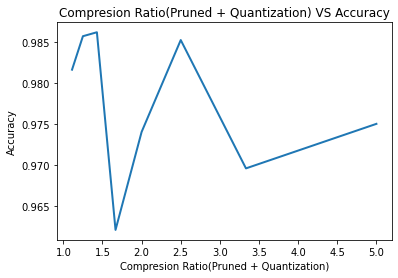

In [ ]:
# compression ratio vs accuracy graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.scatter(compression_rat, acc)
ax.plot(compression_pq_ratio, acc_pq, linewidth=2.0)
plt.xlabel('Compresion Ratio(Pruned + Quantization)')
plt.ylabel('Accuracy')
plt.title('Compresion Ratio(Pruned + Quantization) VS Accuracy')
plt.show()

In [ ]:
# accuracy results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned + Quantization test accuracy:', model_quant_prune_accuracy)

Baseline test accuracy: 0.9498000144958496
Pruned + Quantization test accuracy: 0.9816034436225891


In [ ]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Size of gzipped baseline Keras model: 233687.00 bytes
Size of gzipped pruned and quantized TFlite model: 17653.00 bytes


In [ ]:
# confusion matrix for based model
from sklearn.metrics import confusion_matrix
import numpy as np
test_predictions = model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

313/313 [==============================] - 3s 9ms/step


array([[ 970,    0,    0,    0,    0,    1,    5,    1,    3,    0],
       [   0, 1132,    0,    0,    0,    1,    1,    0,    1,    0],
       [   2,    5, 1017,    1,    1,    0,    0,    4,    2,    0],
       [   0,    0,    4,  996,    0,    1,    0,    6,    2,    1],
       [   0,    1,    0,    0,  967,    0,    4,    0,    1,    9],
       [   2,    1,    0,   10,    0,  865,    3,    1,    8,    2],
       [   6,    3,    0,    0,    3,    2,  942,    0,    2,    0],
       [   0,    8,    9,    8,    1,    0,    0,  992,    1,    9],
       [   2,    1,    2,    5,    1,    1,    0,    2,  955,    5],
       [   0,    4,    0,    6,   14,    2,    1,    4,    7,  971]])

In [ ]:
# confusion matrix for pruned+quantized model
pq_test_predictions = model_quant_prune.predict(x_test)
pq_confusion = confusion_matrix(y_test, np.argmax(pq_test_predictions,axis=1))
pq_confusion

313/313 [==============================] - 2s 7ms/step


array([[ 971,    1,    0,    0,    0,    2,    3,    1,    2,    0],
       [   0, 1131,    0,    0,    0,    1,    2,    0,    1,    0],
       [   2,    4, 1006,    0,    1,    0,    0,    6,   13,    0],
       [   0,    0,    3,  982,    2,    7,    0,    6,    4,    6],
       [   1,    3,    0,    0,  964,    1,    8,    1,    0,    4],
       [   2,    0,    0,    5,    2,  877,    2,    1,    0,    3],
       [   4,    2,    0,    0,    1,    4,  943,    0,    4,    0],
       [   0,   10,   10,    2,    6,    1,    0,  987,    2,   10],
       [   2,    2,    1,    2,    1,    2,    0,    1,  962,    1],
       [   1,    4,    0,    4,   17,    3,    2,    3,    5,  970]])